In [1]:
!pip install ml_collections
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.0 MB/s eta 0:00:00


In [9]:
from google.colab import files
uploaded = files.upload()


In [10]:
# East module
from east import EAST_OUTPUT_LAYERS
from east import decode_predictions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename='/content/drive/MyDrive/S8/textra_health/bounding_box/datset/9.jpg'

import os
print(os.path.exists(filename))  # doit renvoyer True


True


In [4]:
import os
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import io



In [5]:
def extract_text_regions(image_path, text_detector_model):
    """
    Extract individual word regions from an image using the text detector

    Args:
        image_path: Path to the image
        text_detector_model: Path to the EAST text detection model

    Returns:
        original_image: The original image
        word_regions: List of cropped word images
        boxes: List of bounding boxes coordinates
    """
    # Read the image
    original_image = cv.imread(image_path)
    image = original_image.copy()

    # Get dimensions
    (origH, origW) = image.shape[:2]
    (newW, newH) = (320, 320)
    rW = origW / float(newW)
    rH = origH / float(newH)

    # Load the model
    net = cv.dnn.readNet(text_detector_model)

    # Prepare the image for prediction
    blob = cv.dnn.blobFromImage(image, 1.0, (newW, newH),
                               (123.68, 116.78, 103.94),
                               swapRB=True, crop=False)

    # Set the input and get predictions
    net.setInput(blob)
    (scores, geometry) = net.forward(EAST_OUTPUT_LAYERS)

    # Decode predictions
    (rects, confidence) = decode_predictions(scores, geometry)

    # Apply non-maxima suppression
    idxs = cv.dnn.NMSBoxesRotated(rects, confidence, 0.5, 0.4)

    word_regions = []
    boxes = []

    if len(idxs) > 0:
        for i in idxs.flatten():
            # Get bounding box
            box = cv.boxPoints(rects[i])
            box[:, 0] *= rW
            box[:, 1] *= rH
            box = np.int_(box)

            # Draw bounding box on the image
            cv.polylines(image, [box], True, (0, 255, 0), 2)

            # Extract the word region
            rect = cv.boundingRect(box)
            x, y, w, h = rect

            # Add some padding around the word
            padding = 5
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(origW - x, w + 2*padding)
            h = min(origH - y, h + 2*padding)

            # Crop the word region
            word_region = original_image[y:y+h, x:x+w]

            word_regions.append(word_region)
            boxes.append((x, y, w, h))

    return original_image, image, word_regions, boxes

# Now let's create a function that will process a prescription image and predict text
def process_prescription(image_path, text_detector_model):
    """
    Process a prescription image: detect words, predict text for each word,
    and reconstruct the full text
    """
    original_image, annotated_image, word_regions, boxes = extract_text_regions(image_path, text_detector_model)

    # Sort boxes from left to right, top to bottom (reading order)
    # This is a simple sorting method - you might need to refine it based on your layout
    boxes_with_regions = list(zip(boxes, word_regions))

    # Sort by y-coordinate first (row), then by x-coordinate (column)
    # You may need to adjust the threshold for determining if words are on the same line
    same_line_threshold = 20  # pixels

    # Group boxes by line based on y-coordinate
    lines = {}
    for i, (box, _) in enumerate(boxes_with_regions):
        x, y, w, h = box
        line_found = False
        for line_y in lines.keys():
            if abs(y - line_y) < same_line_threshold:
                lines[line_y].append((i, box, word_regions[i]))
                line_found = True
                break
        if not line_found:
            lines[y] = [(i, box, word_regions[i])]

    # Sort each line by x-coordinate
    sorted_lines = []
    for line_y in sorted(lines.keys()):
        sorted_lines.append(sorted(lines[line_y], key=lambda item: item[1][0]))

    # Flatten the list of sorted words
    sorted_words = []
    for line in sorted_lines:
        sorted_words.extend(line)

    # Now sorted_words contains the word regions in reading order

    # Display the original image with bounding boxes
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Detected Words")
    plt.imshow(cv.cvtColor(annotated_image, cv.COLOR_BGR2RGB))
    plt.show()

    # Display each extracted word
    n_words = len(sorted_words)
    cols = 5
    rows = (n_words // cols) + (1 if n_words % cols else 0)

    plt.figure(figsize=(15, rows * 3))
    for i, (idx, box, word_region) in enumerate(sorted_words):
        plt.subplot(rows, cols, i + 1)
        plt.title(f"Word {i+1}")
        plt.imshow(cv.cvtColor(word_region, cv.COLOR_BGR2RGB))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return sorted_words

In [7]:
model = '/content/drive/MyDrive/S8/textra_health/bounding_box/frozen_east_text_detection.pb'

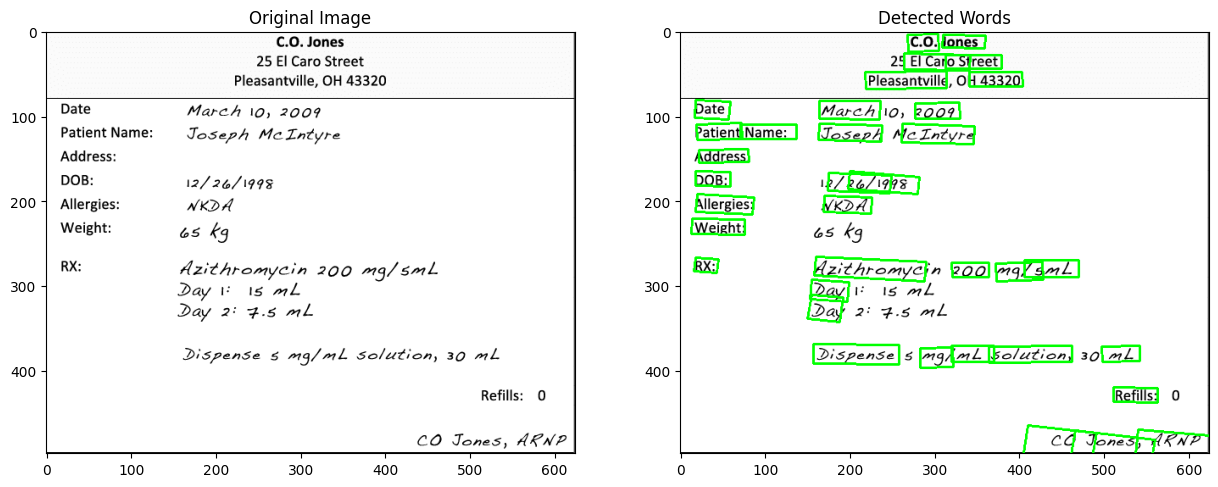

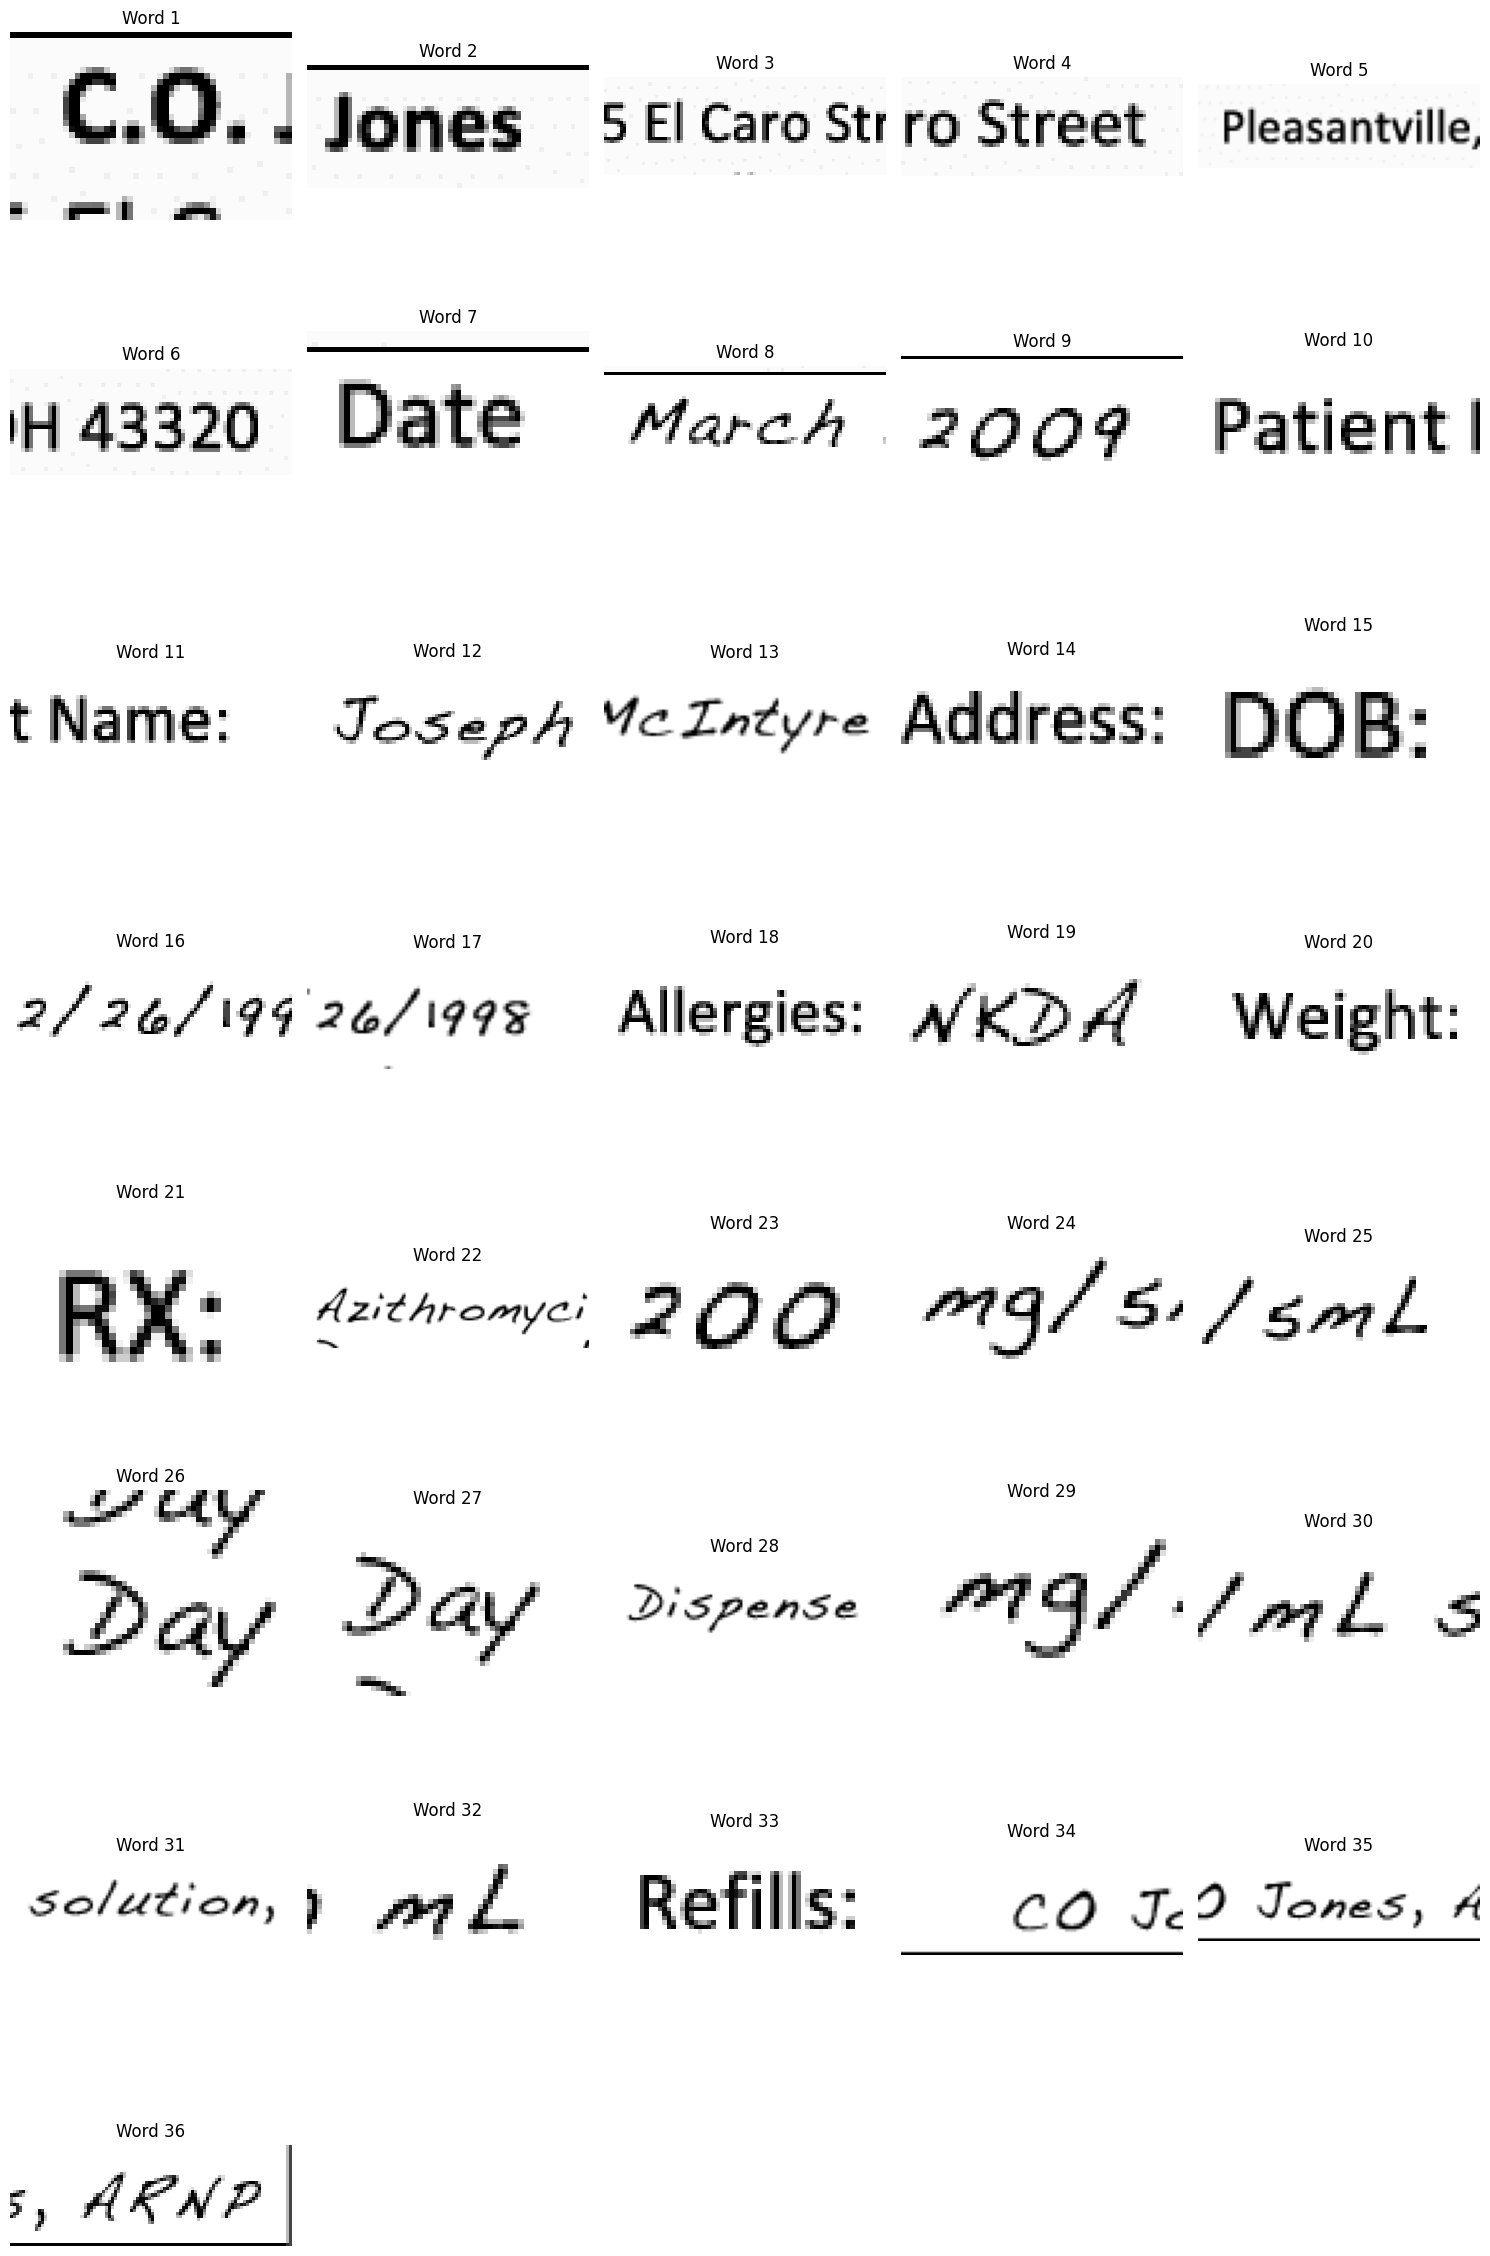

[(34,
  (263, 0, 48, 32),
  array([[[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
  
         [[251, 251, 251],
          [251, 251, 251],
          [251, 251, 251],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [251, 251, 251]],
  
         [[251, 251, 251],
          [251, 251, 251],
          [251, 251, 251],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [251, 251, 251]],
  
         ...,
  
         [[112, 112, 112],
          [112, 112, 112],
          [233, 233, 233],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [251, 251, 251]],
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [183, 183, 183],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [239, 239, 239]],
  
         [[183, 183, 183],
          [183, 183, 183]

In [11]:
process_prescription(filename, model)

In [12]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

# Use these for PaliGemma-2 3B 224px²
LLM_VARIANT = "gemma2_2b"
MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"  # Path to fetch from Kaggle.

# Use these for PaliGemma 1:
# LLM_VARIANT = "gemma_2b"
# MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
# KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")



100%|██████████| 5.65G/5.65G [01:00<00:00, 99.7MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma-2/jax/paligemma2-3b-pt-224/1/./paligemma2-3b-pt-224.b16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


Initializing PaLI-Gemma model and tokenizer...
Starting prescription OCR with PaLI-Gemma...
Loading checkpoint from /content/drive/MyDrive/S8/textra_health/my-custom-paligemma-ckpt.npz...
Checkpoint loaded successfully!


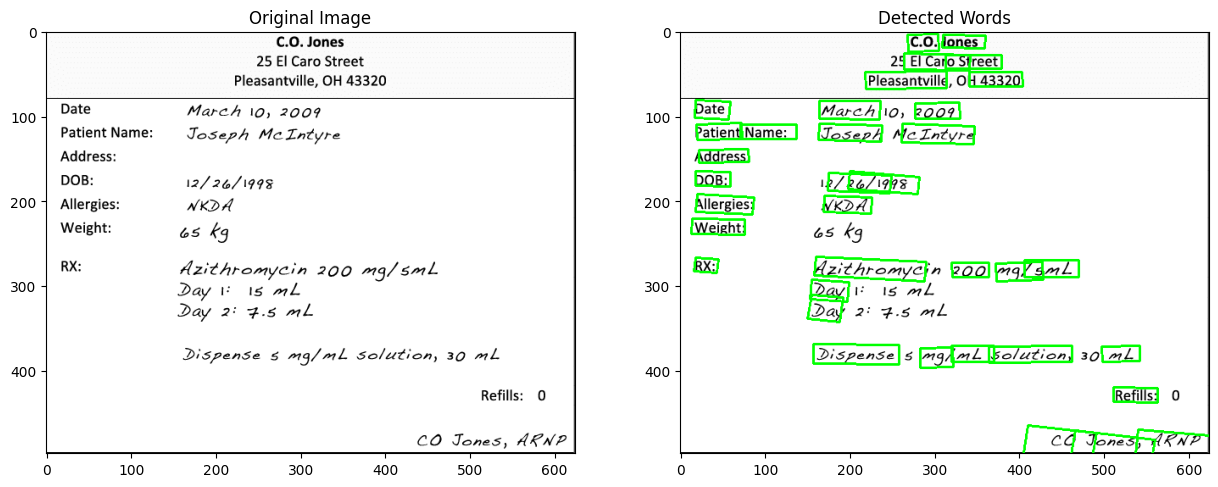

Recognizing words with PaLI-Gemma...


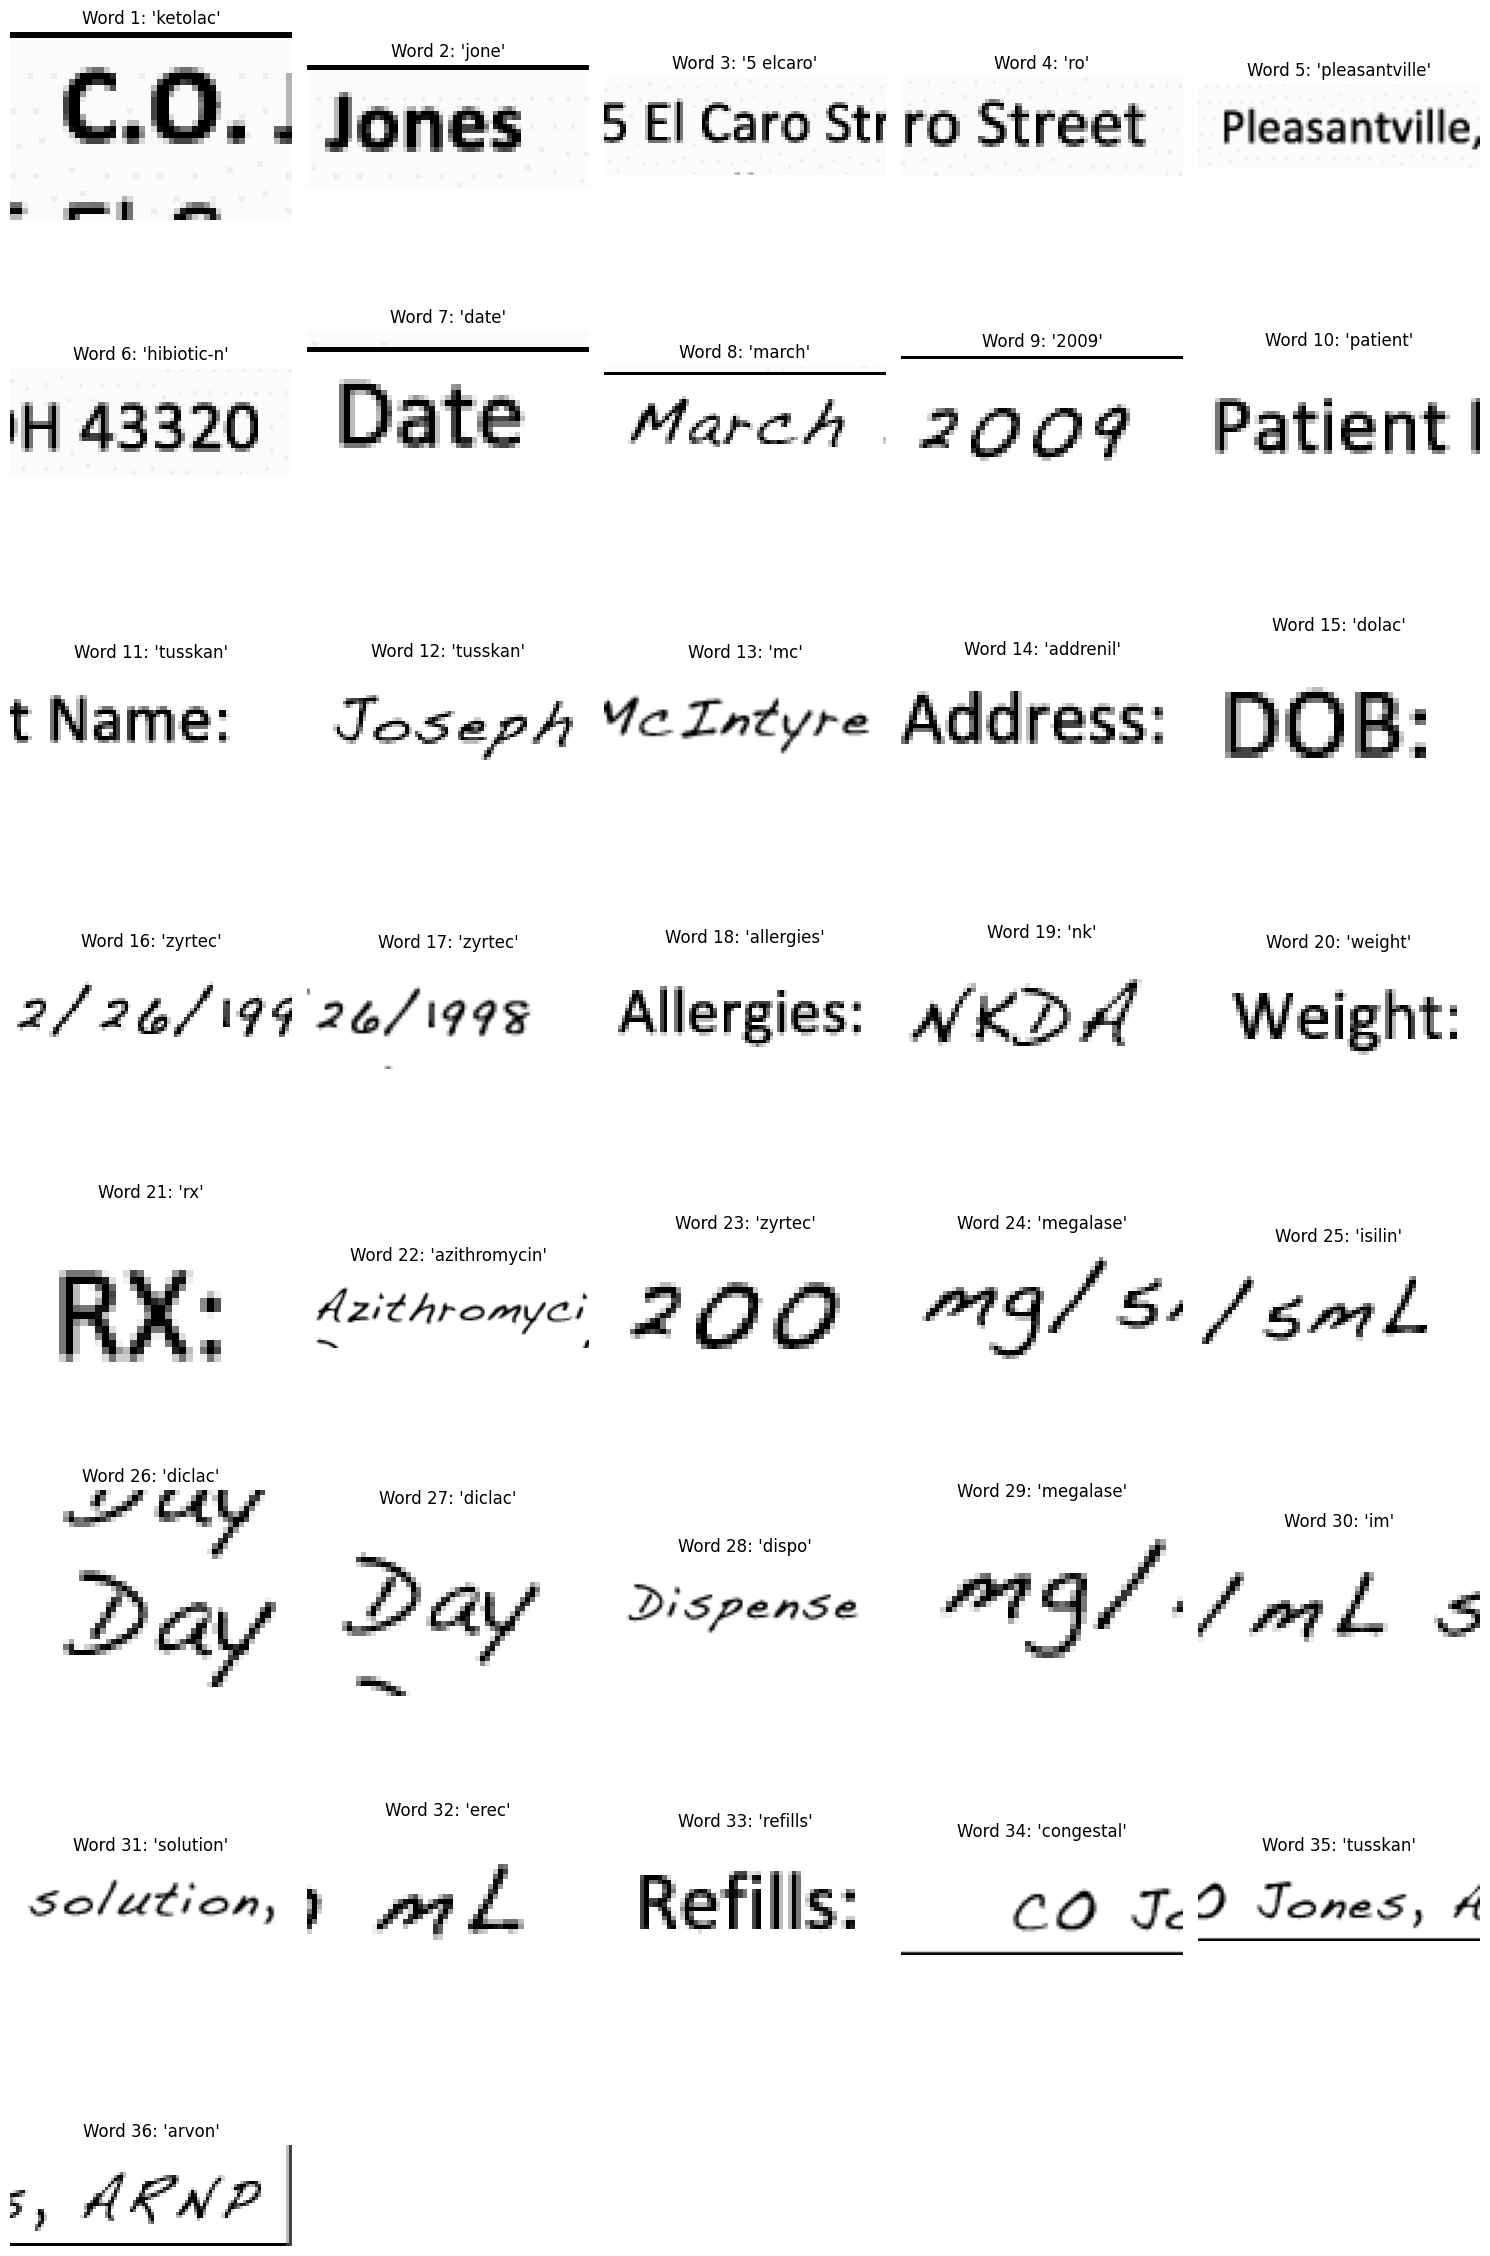


Reconstructed Prescription Text:
tusskan jone
ketolac ro
dispo weight
diclac diclac megalase
march zyrtec isilin azithromycin
mc
tusskan refills zyrtec
date nk
allergies
arvon 5 elcaro pleasantville zyrtec addrenil
rx im
tusskan hibiotic-n megalase dolac erec
2009
congestal solution patient
Results saved to prescription_ocr_results.json


In [ ]:

# Add big_vision to path if not already there
if not os.path.exists("big_vision_repo"):
    print("Cloning big_vision repository...")
    os.system("git clone --quiet --branch=main --depth=1 https://github.com/google-research/big_vision big_vision_repo")

if "big_vision_repo" not in sys.path:
    sys.path.append("big_vision_repo")

# Import PaLI-Gemma modules
import jax
import jax.numpy as jnp
import ml_collections
import sentencepiece
import functools
import tensorflow as tf
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns
import big_vision.utils
import big_vision.sharding

# Configuration
CHECKPOINT_PATH = '/content/drive/MyDrive/S8/textra_health/my-custom-paligemma-ckpt.npz'
TOKENIZER_PATH = "/content/paligemma_tokenizer.model"
LLM_VARIANT = "gemma2_2b"
SEQLEN = 128
IMAGE_SIZE = 224
EAST_MODEL_PATH = "/content/drive/MyDrive/S8/textra_health/bounding_box/frozen_east_text_detection.pb"

# Set up model configuration
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})

# Initialize model and tokenizer
print("Initializing PaLI-Gemma model and tokenizer...")
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Define decode function
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

def load_params(checkpoint_path):
    """Load model parameters from checkpoint."""
    print(f"Loading checkpoint from {checkpoint_path}...")

    # Use positional arguments as in the training notebook
    params = paligemma.load(None, checkpoint_path, model_config)

    # Create a pytree mask of the trainable params (for consistency with training)
    def is_trainable_param(name, param):
        if name.startswith("llm/layers/attn/"):  return True
        if name.startswith("llm/"):              return False
        if name.startswith("img/"):              return False
        raise ValueError(f"Unexpected param name {name}")

    trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

    # Set up for device distribution
    mesh = jax.sharding.Mesh(jax.devices(), ("data"))
    params_sharding = big_vision.sharding.infer_sharding(
        params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

    # Handle casting and moving to GPU (same as in training)
    @functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
    def maybe_cast_to_f32(params, trainable):
        return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                          if m else p.astype(jnp.float16),
                          params, trainable)

    # Process params param by param to avoid RAM issues
    params, treedef = jax.tree.flatten(params)
    sharding_leaves = jax.tree.leaves(params_sharding)
    trainable_leaves = jax.tree.leaves(trainable_mask)

    for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
        params[idx] = big_vision.utils.reshard(params[idx], sharding)
        params[idx] = maybe_cast_to_f32(params[idx], trainable)
        params[idx].block_until_ready()

    params = jax.tree.unflatten(treedef, params)
    print("Checkpoint loaded successfully!")
    return params

def preprocess_image_for_paligemma(cv_image, size=IMAGE_SIZE):
    """Process an OpenCV image for PaLI-Gemma model input."""
    # Convert OpenCV BGR to RGB
    image = cv.cvtColor(cv_image, cv.COLOR_BGR2RGB)

    # Convert to PIL Image for easier processing
    pil_image = Image.fromarray(image)

    # Convert to numpy array
    image = np.asarray(pil_image)

    # Handle grayscale images
    if image.ndim == 2:
        image = np.stack((image,)*3, axis=-1)

    # Handle RGBA images
    image = image[..., :3]  # Remove alpha channel if present

    # Resize and normalize to [-1, 1]
    image = tf.constant(image)
    image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
    return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
    """Tokenize text input for the model."""
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)
    mask_loss = [0] * len(tokens)

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix
        mask_ar += [1] * len(suffix)
        mask_loss += [1] * len(suffix)

    mask_input = [1] * len(tokens)
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
    """Convert model output tokens back to text."""
    tokens = tokens.tolist()
    try:
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)

def recognize_word_with_paligemma(cv_image, params, prefix="caption en"):
    """Recognize a single word image with PaLI-Gemma."""
    # Preprocess the image
    image = preprocess_image_for_paligemma(cv_image)

    # Prepare tokens
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    # Create batch with multiple copies of the same example to match device count
    device_count = jax.device_count()

    # Create a batch by repeating the example to match device count
    batch = {
        "image": np.tile(np.expand_dims(image, axis=0), (device_count, 1, 1, 1)),
        "text": np.tile(np.expand_dims(tokens, axis=0), (device_count, 1)),
        "mask_ar": np.tile(np.expand_dims(mask_ar, axis=0), (device_count, 1)),
        "mask_input": np.tile(np.expand_dims(mask_input, axis=0), (device_count, 1)),
        "_mask": np.ones((device_count,), dtype=bool)  # All examples are real (not padding)
    }

    # Configure sharding for evaluation
    mesh = jax.sharding.Mesh(jax.devices(), ("data"))
    data_sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec("data"))
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Generate prediction
    tokens = decode({"params": params}, batch=batch, max_decode_len=SEQLEN, sampler="greedy")

    # Process result - just take the first prediction since all are the same
    tokens, mask = jax.device_get((tokens, batch["_mask"]))

    # Get raw prediction from tokens (first example)
    raw_prediction = postprocess_tokens(tokens[0])

    # Remove prefix from prediction
    prefix_with_separator = prefix + "\n"
    if raw_prediction.startswith(prefix_with_separator):
        prediction = raw_prediction[len(prefix_with_separator):]
    else:
        prediction = raw_prediction

    return prediction
def process_prescription_with_paligemma(image_path, east_model_path, paligemma_params):
    """
    Process a prescription image: detect words, recognize each word with PaLI-Gemma,
    and reconstruct the full text
    """
    # Extract word regions using your existing function
    original_image, annotated_image, word_regions, boxes = extract_text_regions(image_path, east_model_path)

    # Sort boxes from left to right, top to bottom (reading order)
    boxes_with_regions = list(zip(boxes, word_regions))

    # Group boxes by line based on y-coordinate
    same_line_threshold = 20  # pixels
    lines = {}
    for i, (box, _) in enumerate(boxes_with_regions):
        x, y, w, h = box
        line_found = False
        for line_y in lines.keys():
            if abs(y - line_y) < same_line_threshold:
                lines[line_y].append((i, box, word_regions[i]))
                line_found = True
                break
        if not line_found:
            lines[y] = [(i, box, word_regions[i])]

    # Sort each line by x-coordinate
    sorted_lines = []
    for line_y in sorted(lines.keys()):
        sorted_lines.append(sorted(lines[line_y], key=lambda item: item[1][0]))

    # Flatten the list of sorted words
    sorted_words = []
    for line in sorted_lines:
        sorted_words.extend(line)

    # Display the original image with bounding boxes
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Detected Words")
    plt.imshow(cv.cvtColor(annotated_image, cv.COLOR_BGR2RGB))
    plt.show()

    # Process each word with PaLI-Gemma and display results
    recognition_results = []

    print("Recognizing words with PaLI-Gemma...")
    n_words = len(sorted_words)
    cols = 5
    rows = (n_words // cols) + (1 if n_words % cols else 0)

    plt.figure(figsize=(15, rows * 3))

    for i, (idx, box, word_region) in enumerate(sorted_words):
        # Skip empty regions
        if word_region.size == 0:
            recognized_text = ""
        else:
            # Recognize word with PaLI-Gemma
            try:
                recognized_text = recognize_word_with_paligemma(word_region, paligemma_params)
            except Exception as e:
                print(f"Error recognizing word {i+1}: {str(e)}")
                recognized_text = "[ERROR]"

        # Display the word and recognition result
        plt.subplot(rows, cols, i + 1)
        plt.title(f"Word {i+1}: '{recognized_text}'")
        plt.imshow(cv.cvtColor(word_region, cv.COLOR_BGR2RGB))
        plt.axis('off')

        # Add to results
        recognition_results.append({
            "word_index": i + 1,
            "box": box,
            "recognized_text": recognized_text
        })

    plt.tight_layout()
    plt.show()

    # Reconstruct full text by joining recognized words by line
    full_text = []
    current_line = []
    current_line_y = None

    for line in sorted_lines:
        line_text = []
        for i, (idx, box, word_region) in enumerate(line):
            recognized_index = [r["word_index"] for r in recognition_results].index(idx + 1)
            recognized_text = recognition_results[recognized_index]["recognized_text"]
            if recognized_text:  # Skip empty recognitions
                line_text.append(recognized_text)

        full_text.append(" ".join(line_text))

    reconstructed_text = "\n".join(full_text)
    print("\nReconstructed Prescription Text:")
    print(reconstructed_text)

    return {
        "original_image": original_image,
        "annotated_image": annotated_image,
        "word_regions": word_regions,
        "recognition_results": recognition_results,
        "reconstructed_text": reconstructed_text
    }

def main():
    # Load PaLI-Gemma model parameters
    params = load_params(CHECKPOINT_PATH)

    # Path to the prescription image
    prescription_image_path = "/content/drive/MyDrive/S8/textra_health/bounding_box/datset/9.jpg"

    # Process the prescription
    results = process_prescription_with_paligemma(prescription_image_path, EAST_MODEL_PATH, params)

    # Save results if needed
    output_file = "prescription_ocr_results.json"
    with open(output_file, "w") as f:
        # Convert numpy arrays and PIL images to serializable format
        serializable_results = {
            "recognition_results": results["recognition_results"],
            "reconstructed_text": results["reconstructed_text"]
        }
        json.dump(serializable_results, f, indent=2)

    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    print("Starting prescription OCR with PaLI-Gemma...")
    main()